<font style='font-size:1.5em'>**🧑‍🏫 Week 05 Lecture – NB02 - Pandas tips for W06 Summative** </font>

<font style='font-size:1.2em'>LSE [DS105A](https://lse-dsi.github.io/DS105/autumn-term/index.html){style="color:#e26a4f;font-weight:bold"} – Data for Data Science (2024/25) </font>



<div style="color: #333333; background-color:rgba(226, 106, 79, 0.075); border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); padding: 20px 0 20px 10px; margin: 10px 0 10px 0; flex: 1 1 calc(45% - 20px);min-width: 250px;max-width: 350px;align-items:top;min-height: calc(45% - 20px); box-sizing: border-box;font-size:0.9em;">

🗓️ **DATE:** 31 October 2024 

⌚ **TIME:** 16.00-18.00

📍 **LOCATION:** CLM.5.02
</div>🎃


**AUTHORS:**  Dr. [Jon Cardoso-Silva](https://jonjoncardoso.github.io){style="color:#e26a4f;font-weight:bold"}

**DEPARTMENT:** [LSE Data Science Institute](https://lse.ac.uk/dsi){style="color:#e26a4f;font-weight:bold"}

**OBJECTIVE**: Show a few things about the OpenMeteo API, the `requests` and the `pandas` package that might help you with your W06 Summative assignment. I expanded the code created on the spot during the second hour of the lecture and added commentary to make it more useful for studying.

---

In [1]:
# Import requests to get data from websites
import requests

import pandas as pd

from lets_plot import *
LetsPlot.setup_html()

from IPython.display import Image

# 1. About URLs

When we go to OpenMeteo's [Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api) and fiddle with the parameters, we discover the full URL we can use to submit a request about historical daily rain data:

In [2]:
url = 'https://archive-api.open-meteo.com/v1/archive?latitude=52.52&longitude=13.41&start_date=2024-10-15&end_date=2024-10-29&daily=rain_sum'

Why is the URL like that? Because the developers of Open-Meteo decided so.

When we interact with an API, we have to adhere to the restrictions and rules imposed by the maintainers of that API service. Every API is different and not all of them have an easy to browse website with well-documented parameters like Open-Meteo.

## Splitting long strings with the `+` operator

I particularly don't like having this URL in a single line like that. It's too long and requires scrolling horizontally to understand the list of parameters we passed. 

This is why I've been recommending you split this huge URL into smaller pieces: 

In [3]:
endpoint            = "https://archive-api.open-meteo.com/v1/archive?"

geo_parameters      = 'latitude=52.52&longitude=13.41'
date_parameters     = '&start_date=2024-10-15&end_date=2024-10-29'
variable_parameters = '&daily=rain_sum'

# Here's another way to assemble the URL above
url = endpoint + geo_parameters + date_parameters + variable_parameters

## Saving parameters as a dictionary instead

Ultimately, we want to send a GET request to the API URL.

But, we don't need to use the URL as this huge string. There is a more professional way to send requests to APIs.

You can put all parameters (`latitude`, `longitude`, `start_date`, etc.) on a dictionary and pass it to the `requests.get()` function:

In [4]:
all_parameters = {
    'latitude'      : 52.52,
    'longitude'     : 13.41,
    'start_date'    : '2024-10-15',
    'end_date'      : '2024-10-29',
    'daily'         : 'rain_sum'
}

endpoint            = "https://archive-api.open-meteo.com/v1/archive?"

response = requests.get(endpoint, params=all_parameters)

# 2. Get to pandas as quick as possible

Data analysis will be much simpler and you will be more productive on the long run if you manage to convert whatever data you have to pandas as quick as you can.

Pandas allows us to build a DataFrame from python dictionaries so, because our OpenMeteo data comes in the form of a dictionary (it's what JSON data format becomes when translated to Python objects), we can get the OpenMeteo data we care about in DataFrame as soon as we get the response from the API:

In [5]:
data = response.json()

# This is a Python dictionary
data.keys()

dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'daily_units', 'daily'])

I know that the data I care about is inside the `daily` key and, right now, I don't care about the other keys in that dictionary. Therefore, I can convert the dictionary at `data['daily']` to a Pandas DataFrame:

In [6]:
df = pd.DataFrame(data['daily'])
df.head()

,time,rain_sum
0,2024-10-15,0.0
1,2024-10-16,0.0
2,2024-10-17,0.0
3,2024-10-18,0.0
4,2024-10-19,0.0


Now that I have data represented as a DataFrame, I can do more things and with fewer lines of code.

**Get a statistical description of numerical data:**

In [7]:
df['rain_sum'].describe()

count    15.000000
mean      0.280000
std       0.800179
min       0.000000
25%       0.000000
50%       0.000000
75%       0.050000
max       3.100000
Name: rain_sum, dtype: float64

**Create plots:**

<Axes: >

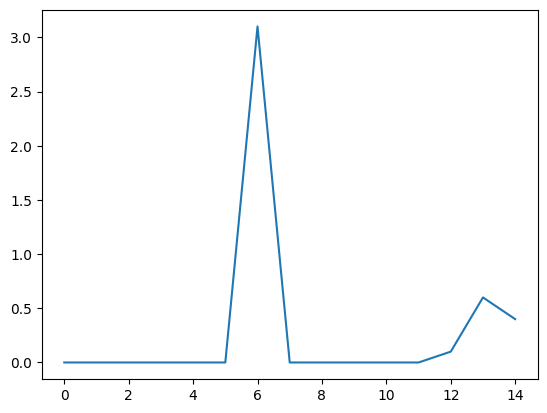

In [8]:
# Use pandas built-in matplotlib plots for a quick check of the data
df['rain_sum'].plot()

In [9]:
# Or using the grammar-of-graphics 
#  for more principled data manipulation skills
#  and to maximise customisation

df['time'] = pd.to_datetime(df['time'])

g = (
    ggplot(df, aes(x='time', y='rain_sum')) +
    geom_bar(stat='identity') +
    labs(title="There were four days with run during the mapped period",
         x="Date", y="Rain (mm)") +
    scale_x_datetime(format="%d/%b") +
    scale_y_continuous(breaks=[0, 2, 4], limits=[0, 4]) +
    ggsize(700, 200)
)

ggsave(g, "rainfall.png", path="../figures/weather/")

g

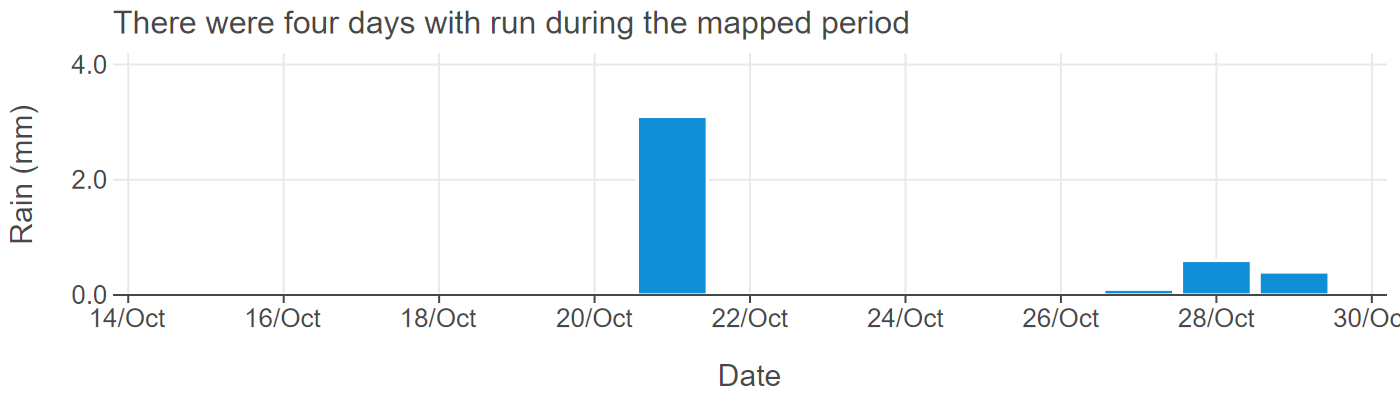

In [10]:
Image(filename="../figures/weather/rainfall.png")

# 3. Tip: OpenMeteo lets you query multiple locations at once 

Instead of passing just a single latitude and longitude to the URL, like:

```
latitude=48.85341&longitude=2.34880
```

You can combine two cities in the same request. This is done bey separating the latitudes by commas (same for longitudes):

```
latitude=48.85341,51.50853&longitude=2.34880,-0.12574
```

You can use this to submit a single request about multiple cities at once!

# 4. Multiple ways of filtering a DataFrame

Some of you when you learned about the possibility to add multiple cities to the same request naturally thought: '_how can I get data about multiple selected cities from the world cities CSV'_?

Let's see how to get that to work.

## 4.1 How to filter a DataFrame

Firstly, let me show how you would filter a dataframe to collect a single row that matches some conditions.

Let me read the dataframe first:

In [11]:
filepath = '../data/world_cities.csv'
world_cities = pd.read_csv(filepath)

In [12]:
# Show some random 5 rows of the data frame
world_cities.sample(n=5)

,country,name,lat,lng
48111,FR,Sainte-Marie-des-Champs,49.62120,0.77904
134271,US,Greensboro,36.07264,-79.79198
32481,DE,Laußig,51.54676,12.62930
39928,ES,Arjona,37.93493,-4.05478
75776,IT,Panighina,44.17162,12.16324


**Which rows contains the latitude and longitude of London?**

We can use [logical operators](https://pandas.pydata.org/docs/user_guide/indexing.html#boolean-indexing) to understand which rows of a pandas Series match a condition we specify:

In [13]:
world_cities['name'] == 'Paris'

0         False
1         False
2         False
3         False
4         False
          ...  
149832    False
149833    False
149834    False
149835    False
149836    False
Name: name, Length: 149837, dtype: bool

☝️ This returns a Series of True/False values that I can use to **subset** my entire DataFrame.

We use square brackets `[ ]` to filter a DataFrame based on logical conditions:

In [14]:
world_cities[world_cities['name'] == 'Paris']

,country,name,lat,lng
15400,CA,Paris,43.20000,-80.38333
49226,FR,Paris,48.85341,2.34880
130904,US,Paris,35.29203,-93.72992
132257,US,Paris,39.61115,-87.69614
132854,US,Paris,38.20980,-84.25299
133783,US,Paris,39.48087,-92.00128
135812,US,Paris,36.30200,-88.32671
136484,US,Paris,33.66094,-95.55551
139025,US,Paris,44.25979,-70.50062
145471,US,Paris,42.22715,-111.40104


**Ops!** There are many cities called Paris around the world. 

If I just want the one that is in France, I'd have to also specify a logical condition for the `country`:

In [15]:
world_cities['country'] == 'FR'

0         False
1         False
2         False
3         False
4         False
          ...  
149832    False
149833    False
149834    False
149835    False
149836    False
Name: country, Length: 149837, dtype: bool

We can put both conditions together by using the `&` operator:

In [16]:
(world_cities['country'] == 'FR') & (world_cities['name'] == 'Paris')

0         False
1         False
2         False
3         False
4         False
          ...  
149832    False
149833    False
149834    False
149835    False
149836    False
Length: 149837, dtype: bool

The code above can be read as:

> 'Does this row have a `country` value equals to 'FR' **AND** a `name` value equals to 'Paris'?'

We can check how many rows match the condition by summing the number of Trues in the logical condition above:

In [17]:
sum((world_cities['country'] == 'FR') & (world_cities['name'] == 'Paris'))

1

Ok, this condition is guaranteed to return just one matching row.

Let's use it within the square brackets now:

In [18]:
world_cities[(world_cities['country'] == 'FR') & (world_cities['name'] == 'Paris')]

,country,name,lat,lng
49226,FR,Paris,48.85341,2.3488


What if I wanted to match France's Paris and Great Britain's London?

I could combine the Paris condition with an `|` (the OR operator):

In [19]:
world_cities[
    (world_cities['country'] == 'FR') & (world_cities['name'] == 'Paris')
    |
    (world_cities['country'] == 'GB') & (world_cities['name'] == 'London')
]

,country,name,lat,lng
49226,FR,Paris,48.85341,2.34880
56726,GB,London,51.50853,-0.12574


💡 **How can I use this smaller DataFrame to build the list of latitudes and list of longitudes the way OpenMeteo expects?**

In [20]:
# Save the filtered DataFrame to a different variable

df_subset = world_cities[
    (world_cities['country'] == 'FR') & (world_cities['name'] == 'Paris')
    |
    (world_cities['country'] == 'GB') & (world_cities['name'] == 'London')
]


To get both latitudes in a single list, all I need to do is get the column `lat`:

In [21]:
df_subset['lat']

49226    48.85341
56726    51.50853
Name: lat, dtype: float64

The above is a Series, but I could just as easily have it as a regular Python list:

In [22]:
df_subset['lat'].tolist()

[48.85341, 51.50853]

To get it in the format that OpenMeteo wants, I could do this:

In [23]:
# This doesn't scale very well but it works
latitude_list = df_subset['lat'].tolist()
str(latitude_list[0]) + ',' + str(latitude_list[1])

'48.85341,51.50853'

But here's a new trick. If you have a list of strings, you can **join** them together:

In [24]:
# This joins all the items in my list and add the comma character in between
",".join(["48.85341","51.50853"])

'48.85341,51.50853'

A more generalisable way would be this:

In [25]:
# pandas Series are essentially lists, so I can use them straight way
# in the join() function (provided that the Series is definitely a str type)
latitudes       = ",".join(df_subset['lat'].astype(str))
longitudes      = ",".join(df_subset['lng'].astype(str))

# Then I can override the latitude and longitude parameters of my request:
all_parameters = {
    'latitude'      : latitudes,
    'longitude'     : longitudes,
    'start_date'    : '2024-10-15',
    'end_date'      : '2024-10-29',
    'daily'         : 'rain_sum'
}

endpoint            = "https://archive-api.open-meteo.com/v1/archive?"

data = requests.get(endpoint, params=all_parameters).json()

Remember: JSON is a mix of lists and dictionaries. 

This time around we no longer get `data` as dictionary. Instead, it is a list!

In [26]:
type(data)

list

Our list has two elements, the first is Paris and the second represents London:

In [27]:
len(data)

2

I can treat each element of the list separately and add a third column to the data frame, to represent the city.

(otherwise, how would I know which city the row represents?)

In [28]:
df_london         = pd.DataFrame(data[0]['daily'])
df_london['city'] = 'London'

df_paris          = pd.DataFrame(data[1]['daily'])
df_paris['city']  = 'Paris'

Here's how you stack up two dataframes (concatenate) to make a single one:

In [29]:
df = pd.concat([df_london, df_paris])

In [30]:
df.head()

,time,rain_sum,city
0,2024-10-15,0.2,London
1,2024-10-16,9.1,London
2,2024-10-17,9.7,London
3,2024-10-18,7.4,London
4,2024-10-19,2.7,London


In [31]:
df.tail()

,time,rain_sum,city
10,2024-10-25,4.2,Paris
11,2024-10-26,0.0,Paris
12,2024-10-27,0.1,Paris
13,2024-10-28,0.4,Paris
14,2024-10-29,0.6,Paris


But you can do better! Ideally, you should write a `for` loop to add the name of the city automatically and not manually like I did above (I'll leave that as an exercise to the reader).

## 4.2 How to do this with a merge?

If you wanted to collect data about a lot of cities, you would have to manually build the logical conditions to recreate the `df_subset`. This would be tedious and error-prone.

Several of you came across the pandas `merge()` function and indeed, this is a more robust alternative for the set of logical conditions. 

`merge()` uses the column names shared by two DataFrames to produce a resulting 'merged' DataFrame that adds information from both data frames. 

**Let me create a DataFrame with just the info I care about.**

Suppose I'm interested in the three cities below:

In [32]:
selected_countries = ['GB', 'FR', 'US']
selected_cities    = ['London', 'Paris', 'Washington']


df_selected_cities = pd.DataFrame({'country': selected_countries, 
                                   'name': selected_cities})
df_selected_cities

,country,name
0,GB,London
1,FR,Paris
2,US,Washington


**I could merge this with the `world_cities` DataFrame**


In [33]:
# Merge two data frames: df_selected_cities (left) and world_cities(right)
#  This works like this:
#  - pandas identify the column names both DFs share (country and name)
#  - pandas find the rows that has the same matching values in both data frames
#  - pandas puts everything together, adding extra columns to the resulting DF
df_selected_cities.merge(world_cities)

,country,name,lat,lng
0,GB,London,51.50853,-0.12574
1,FR,Paris,48.85341,2.34880
2,US,Washington,38.89511,-77.03637
3,US,Washington,33.73679,-82.73931
4,US,Washington,38.65922,-87.17279
5,US,Washington,39.81806,-97.05086
6,US,Washington,38.55811,-91.01209
7,US,Washington,35.54655,-77.05217
8,US,Washington,38.71345,-78.15944
9,US,Washington,39.26119,-81.67180


Wait! There are just one Paris and just one London, but there are dozens of cities named Washington in the US!

There's no other way around this: we'll need to do a bit of Google search to discover which one represents Washington DC and then remove all the other Washingtons we don't care about.

My Google search reveals that Washington, DC is located at the coordinates: 38°54′17″N 77°00′59″W

54′ is actually 54/60 which represents ~ 0.9. **This means the Washington I want is the third one in the DataFrame**

Therefore, if I just select `.head(3)`, I'll have all the relevant rows:

In [34]:
df_subset = df_selected_cities.merge(world_cities).head(3)
df_subset

,country,name,lat,lng
0,GB,London,51.50853,-0.12574
1,FR,Paris,48.85341,2.34880
2,US,Washington,38.89511,-77.03637


What if Washington, DC, wasn't placed first?

I'd have to do something like this:

In [35]:
df_subset = df_selected_cities.merge(world_cities)

# Name is either part of the list ['Paris', 'London']
#                OR if matches the latitude specified
logical_cond = (
    df_subset['name'].isin(['Paris', 'London']) | 
    (df_subset['lat'] > 38.8) & (df_subset['lat'] < 39)
)

df_subset = df_subset[logical_cond]

df_subset

,country,name,lat,lng
0,GB,London,51.50853,-0.12574
1,FR,Paris,48.85341,2.34880
2,US,Washington,38.89511,-77.03637
